**Dataset Downlaoding**

In [1]:
import os
import tarfile
import requests
from tqdm import tqdm

# Create data directory if it doesn't exist
os.makedirs('./data', exist_ok=True)

# Download function with progress bar
def download_file(url, filename):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte
    
    with open(filename, 'wb') as file, tqdm(
        desc=filename,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            bar.update(len(data))
            file.write(data)

# Download the dataset
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
annotations_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

print("Downloading images...")
download_file(dataset_url, './data/images.tar.gz')

print("Downloading annotations...")
download_file(annotations_url, './data/annotations.tar.gz')

### Step 2: Extract the Files


# Extract images
print("Extracting images...")
with tarfile.open('./data/images.tar.gz', 'r:gz') as tar:
    tar.extractall('./data')

# Extract annotations
print("Extracting annotations...")
with tarfile.open('./data/annotations.tar.gz', 'r:gz') as tar:
    tar.extractall('./data')

print("Dataset downloaded and extracted successfully!")

./data/images.tar.gz: 100%|██████████| 755M/755M [00:25<00:00, 30.6MiB/s] 


./data/annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:01<00:00, 15.3MiB/s]


Extracting images...
Extracting annotations...
Dataset downloaded and extracted successfully!


In [2]:
# Verify the download
def check_files():
    required_files = [
        './data/images',
        './data/annotations',
        './data/annotations/list.txt',
        './data/annotations/trainval.txt',
        './data/annotations/test.txt'
    ]
    
    for file in required_files:
        if not os.path.exists(file):
            print(f"Missing file: {file}")
            return False
    
    # Count images
    image_files = [f for f in os.listdir('./data/images') if f.endswith('.jpg')]
    print(f"Found {len(image_files)} images")
    
    return True

if check_files():
    print("Dataset is ready for use!")
else:
    print("There was an issue with the dataset download. Please try again.")

Found 7390 images
Dataset is ready for use!


In [3]:
# Remove the compressed files if needed
os.remove('./data/images.tar.gz')
os.remove('./data/annotations.tar.gz')
print("Cleaned up compressed files.")

Cleaned up compressed files.


In [4]:
pip install pytorch_metric_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

In [5]:
pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 59.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


**Import libraries & Check Cuda**

In [6]:
# Cell 1: Imports and setup
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pytorch_metric_learning import losses, miners, distances, reducers
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns
from pytorch_metric_learning import losses, miners, distances, reducers
import faiss

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Read The Dataset from the directory**

In [7]:
# Cell 2: Dataset class
class OxfordPetsDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Read the annotation file
        with open(annotation_file, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]
        
        # Parse the lines to get image names and labels
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        class_counter = 0
        
        for line in lines:
            image_name = line.split()[0] + '.jpg'
            class_name = '_'.join(line.split('_')[:-1])
            
            if class_name not in self.class_to_idx:
                self.class_to_idx[class_name] = class_counter
                self.idx_to_class[class_counter] = class_name
                class_counter += 1
            
            img_path = os.path.join(self.root_dir, image_name)
            if os.path.exists(img_path):
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_name])
        
        self.num_classes = len(self.class_to_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Use PIL to read image and convert to RGB
        image = torchvision.io.read_image(img_path)
        if image.shape[0] == 1:  # Convert grayscale to RGB
            image = image.repeat(3, 1, 1)
        elif image.shape[0] == 4:  # Remove alpha channel if exists
            image = image[:3, :, :]
            
        image = image.float() / 255.0
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Data Tranformation & DataLoaders**

In [8]:
# Cell 3: Data preparation
# Define transformations with proper channel handling
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize datasets
data_dir = '/kaggle/working/data/images'
annotations_dir = '/kaggle/working/data/annotations'

trainval_dataset = OxfordPetsDataset(
    root_dir=data_dir,
    annotation_file=os.path.join(annotations_dir, 'trainval.txt'),
    transform=train_transform
)

test_dataset = OxfordPetsDataset(
    root_dir=data_dir,
    annotation_file=os.path.join(annotations_dir, 'test.txt'),
    transform=test_transform
)

# Split trainval into train and validation
train_indices, val_indices = train_test_split(
    range(len(trainval_dataset)),
    test_size=0.2,
    stratify=trainval_dataset.labels,
    random_state=42
)

train_dataset = torch.utils.data.Subset(trainval_dataset, train_indices)
val_dataset = torch.utils.data.Subset(trainval_dataset, val_indices)

# Create data loaders with reduced num_workers if needed
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {trainval_dataset.num_classes}")

Train samples: 2944
Validation samples: 736
Test samples: 3669
Number of classes: 37


In [9]:
# Cell 4: Model architecture
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_size=128):
        super(EmbeddingNet, self).__init__()
        backbone = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        
        self.projection = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_size)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)
        embeddings = self.projection(features)
        embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
        return embeddings

# Initialize model
embedding_size = 128
model = EmbeddingNet(embedding_size=embedding_size).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


**Traning Setup :**
**Try Different Margin but this could not effect so much to the recall**

In [10]:

distance = distances.LpDistance(normalize_embeddings=True, p=2, power=1)
reducer = reducers.AvgNonZeroReducer()
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
miner = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

**Training and validation functions**

In [11]:

def train(model, loss_func, miner, train_loader, optimizer, epoch, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (data, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        embeddings = model(data)
        
        indices_tuple = miner(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Train Loss: {avg_loss:.4f}")
    return avg_loss

def validate(model, val_loader, device):
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            embeddings = model(data)
            
            indices_tuple = miner(embeddings, labels)
            loss = loss_func(embeddings, labels, indices_tuple)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    return avg_val_loss

**Training and saving best model  (100 Epochs)**

In [12]:
# Cell 7: Training loop
num_epochs = 100
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, loss_func, miner, train_loader, optimizer, epoch, device)
    val_loss = validate(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved new best model")
    
    print(f"Epoch {epoch} complete\n")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch 1: 100%|██████████| 92/92 [00:14<00:00,  6.37it/s]

Train Loss: 0.0923



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0899
Saved new best model
Epoch 1 complete



Epoch 2: 100%|██████████| 92/92 [00:12<00:00,  7.16it/s]

Train Loss: 0.0899



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0904
Epoch 2 complete



Epoch 3: 100%|██████████| 92/92 [00:13<00:00,  6.89it/s]

Train Loss: 0.0893



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0900
Epoch 3 complete



Epoch 4: 100%|██████████| 92/92 [00:12<00:00,  7.10it/s]

Train Loss: 0.0910



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0903
Epoch 4 complete



Epoch 5: 100%|██████████| 92/92 [00:13<00:00,  7.02it/s]

Train Loss: 0.0886



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0917
Epoch 5 complete



Epoch 6: 100%|██████████| 92/92 [00:12<00:00,  7.19it/s]

Train Loss: 0.0886



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0903
Epoch 6 complete



Epoch 7: 100%|██████████| 92/92 [00:13<00:00,  6.85it/s]

Train Loss: 0.0885



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0917
Epoch 7 complete



Epoch 8: 100%|██████████| 92/92 [00:12<00:00,  7.26it/s]

Train Loss: 0.0893



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0897
Saved new best model
Epoch 8 complete



Epoch 9: 100%|██████████| 92/92 [00:13<00:00,  6.89it/s]

Train Loss: 0.0883



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0907
Epoch 9 complete



Epoch 10: 100%|██████████| 92/92 [00:12<00:00,  7.16it/s]

Train Loss: 0.0875



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0915
Epoch 10 complete



Epoch 11: 100%|██████████| 92/92 [00:13<00:00,  6.85it/s]

Train Loss: 0.0900



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0892
Saved new best model
Epoch 11 complete



Epoch 12: 100%|██████████| 92/92 [00:13<00:00,  6.92it/s]

Train Loss: 0.0879



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0899
Epoch 12 complete



Epoch 13: 100%|██████████| 92/92 [00:13<00:00,  6.76it/s]

Train Loss: 0.0861



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0902
Epoch 13 complete



Epoch 14: 100%|██████████| 92/92 [00:12<00:00,  7.20it/s]

Train Loss: 0.0872



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0887
Saved new best model
Epoch 14 complete



Epoch 15: 100%|██████████| 92/92 [00:13<00:00,  6.82it/s]

Train Loss: 0.0897



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0908
Epoch 15 complete



Epoch 16: 100%|██████████| 92/92 [00:12<00:00,  7.12it/s]

Train Loss: 0.0862



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0852
Saved new best model
Epoch 16 complete



Epoch 17: 100%|██████████| 92/92 [00:13<00:00,  6.67it/s]

Train Loss: 0.0892



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0845
Saved new best model
Epoch 17 complete



Epoch 18: 100%|██████████| 92/92 [00:13<00:00,  6.97it/s]

Train Loss: 0.0904



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0839
Saved new best model
Epoch 18 complete



Epoch 19: 100%|██████████| 92/92 [00:13<00:00,  6.89it/s]

Train Loss: 0.0866



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0918
Epoch 19 complete



Epoch 20: 100%|██████████| 92/92 [00:12<00:00,  7.18it/s]

Train Loss: 0.0889



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0909
Epoch 20 complete



Epoch 21: 100%|██████████| 92/92 [00:13<00:00,  6.88it/s]

Train Loss: 0.0862



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0970
Epoch 21 complete



Epoch 22: 100%|██████████| 92/92 [00:13<00:00,  6.94it/s]

Train Loss: 0.0869



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0866
Epoch 22 complete



Epoch 23: 100%|██████████| 92/92 [00:13<00:00,  6.79it/s]

Train Loss: 0.0864



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0878
Epoch 23 complete



Epoch 24: 100%|██████████| 92/92 [00:12<00:00,  7.14it/s]

Train Loss: 0.0860



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0914
Epoch 24 complete



Epoch 25: 100%|██████████| 92/92 [00:13<00:00,  6.74it/s]

Train Loss: 0.0877



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0907
Epoch 25 complete



Epoch 26: 100%|██████████| 92/92 [00:13<00:00,  7.08it/s]

Train Loss: 0.0898



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0831
Saved new best model
Epoch 26 complete



Epoch 27: 100%|██████████| 92/92 [00:13<00:00,  6.79it/s]

Train Loss: 0.0881



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0868
Epoch 27 complete



Epoch 28: 100%|██████████| 92/92 [00:12<00:00,  7.17it/s]

Train Loss: 0.0853



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0850
Epoch 28 complete



Epoch 29: 100%|██████████| 92/92 [00:13<00:00,  6.82it/s]

Train Loss: 0.0875



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0864
Epoch 29 complete



Epoch 30: 100%|██████████| 92/92 [00:12<00:00,  7.31it/s]

Train Loss: 0.0886



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0858
Epoch 30 complete



Epoch 31: 100%|██████████| 92/92 [00:13<00:00,  6.92it/s]

Train Loss: 0.0837



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0939
Epoch 31 complete



Epoch 32: 100%|██████████| 92/92 [00:12<00:00,  7.12it/s]

Train Loss: 0.0856



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0893
Epoch 32 complete



Epoch 33: 100%|██████████| 92/92 [00:13<00:00,  6.79it/s]

Train Loss: 0.0855



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0933
Epoch 33 complete



Epoch 34: 100%|██████████| 92/92 [00:13<00:00,  6.98it/s]

Train Loss: 0.0863



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0887
Epoch 34 complete



Epoch 35: 100%|██████████| 92/92 [00:13<00:00,  6.99it/s]

Train Loss: 0.0861



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0861
Epoch 35 complete



Epoch 36: 100%|██████████| 92/92 [00:12<00:00,  7.09it/s]

Train Loss: 0.0840



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0886
Epoch 36 complete



Epoch 37: 100%|██████████| 92/92 [00:13<00:00,  6.80it/s]

Train Loss: 0.0828



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0905
Epoch 37 complete



Epoch 38: 100%|██████████| 92/92 [00:12<00:00,  7.19it/s]

Train Loss: 0.0847



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0864
Epoch 38 complete



Epoch 39: 100%|██████████| 92/92 [00:13<00:00,  6.75it/s]

Train Loss: 0.0830



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0877
Epoch 39 complete



Epoch 40: 100%|██████████| 92/92 [00:12<00:00,  7.12it/s]

Train Loss: 0.0826



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0872
Epoch 40 complete



Epoch 41: 100%|██████████| 92/92 [00:13<00:00,  6.98it/s]

Train Loss: 0.0835



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0917
Epoch 41 complete



Epoch 42: 100%|██████████| 92/92 [00:12<00:00,  7.23it/s]

Train Loss: 0.0833



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0877
Epoch 42 complete



Epoch 43: 100%|██████████| 92/92 [00:13<00:00,  6.84it/s]

Train Loss: 0.0818



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0825
Saved new best model
Epoch 43 complete



Epoch 44: 100%|██████████| 92/92 [00:13<00:00,  7.02it/s]

Train Loss: 0.0829



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0877
Epoch 44 complete



Epoch 45: 100%|██████████| 92/92 [00:13<00:00,  6.87it/s]

Train Loss: 0.0865



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0904
Epoch 45 complete



Epoch 46: 100%|██████████| 92/92 [00:12<00:00,  7.24it/s]

Train Loss: 0.0836



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0886
Epoch 46 complete



Epoch 47: 100%|██████████| 92/92 [00:13<00:00,  6.91it/s]


Train Loss: 0.0871


Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0841
Epoch 47 complete



Epoch 48: 100%|██████████| 92/92 [00:12<00:00,  7.26it/s]

Train Loss: 0.0836



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0886
Epoch 48 complete



Epoch 49: 100%|██████████| 92/92 [00:13<00:00,  6.76it/s]

Train Loss: 0.0830



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0906
Epoch 49 complete



Epoch 50: 100%|██████████| 92/92 [00:13<00:00,  7.05it/s]

Train Loss: 0.0833



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0885
Epoch 50 complete



Epoch 51: 100%|██████████| 92/92 [00:13<00:00,  6.78it/s]

Train Loss: 0.0849



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0895
Epoch 51 complete



Epoch 52: 100%|██████████| 92/92 [00:13<00:00,  7.08it/s]

Train Loss: 0.0842



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0895
Epoch 52 complete



Epoch 53: 100%|██████████| 92/92 [00:13<00:00,  6.87it/s]

Train Loss: 0.0858



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0844
Epoch 53 complete



Epoch 54: 100%|██████████| 92/92 [00:12<00:00,  7.16it/s]

Train Loss: 0.0813



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0924
Epoch 54 complete



Epoch 55: 100%|██████████| 92/92 [00:13<00:00,  6.70it/s]

Train Loss: 0.0870



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0908
Epoch 55 complete



Epoch 56: 100%|██████████| 92/92 [00:12<00:00,  7.14it/s]

Train Loss: 0.0819



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0849
Epoch 56 complete



Epoch 57: 100%|██████████| 92/92 [00:13<00:00,  6.81it/s]

Train Loss: 0.0812



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0886
Epoch 57 complete



Epoch 58: 100%|██████████| 92/92 [00:13<00:00,  6.95it/s]

Train Loss: 0.0833



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0880
Epoch 58 complete



Epoch 59: 100%|██████████| 92/92 [00:13<00:00,  6.79it/s]

Train Loss: 0.0830



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0831
Epoch 59 complete



Epoch 60: 100%|██████████| 92/92 [00:13<00:00,  6.92it/s]

Train Loss: 0.0844



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0848
Epoch 60 complete



Epoch 61: 100%|██████████| 92/92 [00:13<00:00,  6.93it/s]

Train Loss: 0.0847



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0842
Epoch 61 complete



Epoch 62: 100%|██████████| 92/92 [00:13<00:00,  6.97it/s]

Train Loss: 0.0819



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0889
Epoch 62 complete



Epoch 63: 100%|██████████| 92/92 [00:13<00:00,  6.88it/s]

Train Loss: 0.0834



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0842
Epoch 63 complete



Epoch 64: 100%|██████████| 92/92 [00:12<00:00,  7.09it/s]

Train Loss: 0.0816



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0919
Epoch 64 complete



Epoch 65: 100%|██████████| 92/92 [00:13<00:00,  6.84it/s]

Train Loss: 0.0839



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0800
Saved new best model
Epoch 65 complete



Epoch 66: 100%|██████████| 92/92 [00:12<00:00,  7.10it/s]

Train Loss: 0.0846



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0897
Epoch 66 complete



Epoch 67: 100%|██████████| 92/92 [00:13<00:00,  6.84it/s]

Train Loss: 0.0863



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0892
Epoch 67 complete



Epoch 68: 100%|██████████| 92/92 [00:13<00:00,  7.05it/s]

Train Loss: 0.0805



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0859
Epoch 68 complete



Epoch 69: 100%|██████████| 92/92 [00:13<00:00,  6.76it/s]

Train Loss: 0.0877



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0898
Epoch 69 complete



Epoch 70: 100%|██████████| 92/92 [00:12<00:00,  7.11it/s]


Train Loss: 0.0837


Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0827
Epoch 70 complete



Epoch 71: 100%|██████████| 92/92 [00:13<00:00,  6.80it/s]

Train Loss: 0.0868



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0861
Epoch 71 complete



Epoch 72: 100%|██████████| 92/92 [00:12<00:00,  7.29it/s]

Train Loss: 0.0866



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0876
Epoch 72 complete



Epoch 73: 100%|██████████| 92/92 [00:13<00:00,  7.02it/s]

Train Loss: 0.0842



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0920
Epoch 73 complete



Epoch 74: 100%|██████████| 92/92 [00:13<00:00,  7.07it/s]

Train Loss: 0.0815



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0951
Epoch 74 complete



Epoch 75: 100%|██████████| 92/92 [00:13<00:00,  6.67it/s]

Train Loss: 0.0825



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0858
Epoch 75 complete



Epoch 76: 100%|██████████| 92/92 [00:12<00:00,  7.11it/s]

Train Loss: 0.0890



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0832
Epoch 76 complete



Epoch 77: 100%|██████████| 92/92 [00:13<00:00,  6.72it/s]

Train Loss: 0.0846



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0869
Epoch 77 complete



Epoch 78: 100%|██████████| 92/92 [00:12<00:00,  7.15it/s]

Train Loss: 0.0841



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0882
Epoch 78 complete



Epoch 79: 100%|██████████| 92/92 [00:13<00:00,  6.78it/s]

Train Loss: 0.0827



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0880
Epoch 79 complete



Epoch 80: 100%|██████████| 92/92 [00:13<00:00,  6.97it/s]

Train Loss: 0.0861



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0868
Epoch 80 complete



Epoch 81: 100%|██████████| 92/92 [00:13<00:00,  6.69it/s]

Train Loss: 0.0862



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0844
Epoch 81 complete



Epoch 82: 100%|██████████| 92/92 [00:13<00:00,  7.03it/s]

Train Loss: 0.0818



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0856
Epoch 82 complete



Epoch 83: 100%|██████████| 92/92 [00:13<00:00,  6.77it/s]

Train Loss: 0.0846



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0861
Epoch 83 complete



Epoch 84: 100%|██████████| 92/92 [00:13<00:00,  6.97it/s]

Train Loss: 0.0838



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0912
Epoch 84 complete



Epoch 85: 100%|██████████| 92/92 [00:13<00:00,  6.90it/s]

Train Loss: 0.0820



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0868
Epoch 85 complete



Epoch 86: 100%|██████████| 92/92 [00:13<00:00,  7.00it/s]

Train Loss: 0.0857



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0888
Epoch 86 complete



Epoch 87: 100%|██████████| 92/92 [00:13<00:00,  6.97it/s]

Train Loss: 0.0850



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0883
Epoch 87 complete



Epoch 88: 100%|██████████| 92/92 [00:12<00:00,  7.22it/s]

Train Loss: 0.0841



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0839
Epoch 88 complete



Epoch 89: 100%|██████████| 92/92 [00:12<00:00,  7.14it/s]

Train Loss: 0.0791



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0878
Epoch 89 complete



Epoch 90: 100%|██████████| 92/92 [00:13<00:00,  7.02it/s]

Train Loss: 0.0850



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0913
Epoch 90 complete



Epoch 91: 100%|██████████| 92/92 [00:12<00:00,  7.12it/s]

Train Loss: 0.0844



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0883
Epoch 91 complete



Epoch 92: 100%|██████████| 92/92 [00:12<00:00,  7.08it/s]

Train Loss: 0.0810



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0891
Epoch 92 complete



Epoch 93: 100%|██████████| 92/92 [00:13<00:00,  7.04it/s]

Train Loss: 0.0862



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0976
Epoch 93 complete



Epoch 94: 100%|██████████| 92/92 [00:13<00:00,  7.02it/s]

Train Loss: 0.0819



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0948
Epoch 94 complete



Epoch 95: 100%|██████████| 92/92 [00:13<00:00,  6.97it/s]

Train Loss: 0.0833



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0898
Epoch 95 complete



Epoch 96: 100%|██████████| 92/92 [00:12<00:00,  7.08it/s]

Train Loss: 0.0855



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0849
Epoch 96 complete



Epoch 97: 100%|██████████| 92/92 [00:13<00:00,  6.92it/s]

Train Loss: 0.0861



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0873
Epoch 97 complete



Epoch 98: 100%|██████████| 92/92 [00:13<00:00,  6.79it/s]

Train Loss: 0.0845



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0888
Epoch 98 complete



Epoch 99: 100%|██████████| 92/92 [00:13<00:00,  7.05it/s]

Train Loss: 0.0856



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0902
Epoch 99 complete



Epoch 100: 100%|██████████| 92/92 [00:13<00:00,  6.93it/s]

Train Loss: 0.0813



Corrupt JPEG data: premature end of data segment


Validation Loss: 0.0820
Epoch 100 complete



<All keys matched successfully>

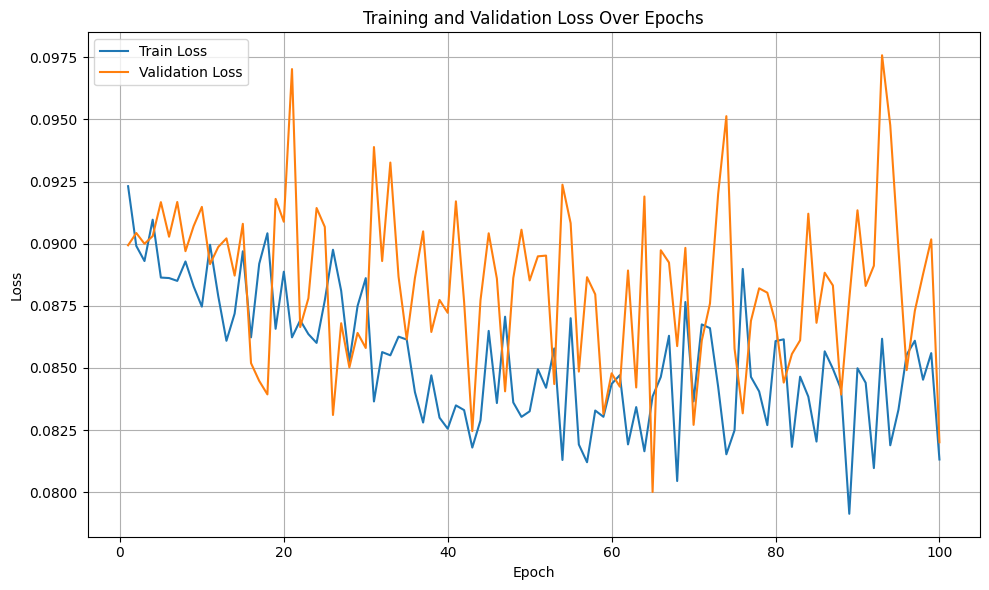

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Running Verification Evaluation...


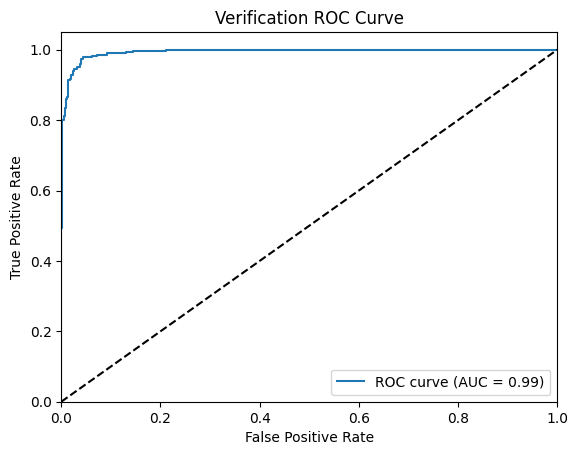

In [14]:
# Cell 8: Verification evaluation
def evaluate_verification(model, loader, device, num_pairs=1000):
    model.eval()
    embeddings = []
    labels = []
    
    # Get all embeddings first
    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            emb = model(data)
            embeddings.append(emb.cpu().numpy())
            labels.append(label.numpy())
    
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    
    # Generate pairs
    unique_labels = np.unique(labels)
    label_to_indices = {label: np.where(labels == label)[0] for label in unique_labels}
    
    pos_pairs = []
    neg_pairs = []
    
    # Ensure we have enough samples for each class
    min_samples_per_class = min(len(indices) for indices in label_to_indices.values())
    if min_samples_per_class < 2:
        raise ValueError("Some classes have fewer than 2 samples")
    
    num_pairs_per_class = max(1, num_pairs // (2 * len(unique_labels)))
    
    for label in unique_labels:
        class_indices = label_to_indices[label]
        
        # Positive pairs
        for _ in range(num_pairs_per_class):
            if len(class_indices) >= 2:
                idx1, idx2 = np.random.choice(class_indices, 2, replace=False)
                pos_pairs.append((idx1, idx2))
        
        # Negative pairs
        other_labels = [l for l in unique_labels if l != label]
        for other_label in np.random.choice(other_labels, num_pairs_per_class, replace=len(other_labels) < num_pairs_per_class):
            other_indices = label_to_indices[other_label]
            if len(other_indices) >= 1:
                idx1 = np.random.choice(class_indices)
                idx2 = np.random.choice(other_indices)
                neg_pairs.append((idx1, idx2))
    
    # Calculate similarities
    def cosine_similarity(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    
    pos_sims = [cosine_similarity(embeddings[i], embeddings[j]) for i, j in pos_pairs]
    neg_sims = [cosine_similarity(embeddings[i], embeddings[j]) for i, j in neg_pairs]
    
    # ROC AUC
    y_true = np.array([1] * len(pos_sims) + [0] * len(neg_sims))
    y_score = np.concatenate([pos_sims, neg_sims])
    roc_auc = roc_auc_score(y_true, y_score)
    
    # Equal Error Rate (EER)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_idx]
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Verification ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return {'roc_auc': roc_auc, 'eer': eer}

print("\nRunning Verification Evaluation...")
verification_metrics = evaluate_verification(model, test_loader, device)


Running Retrieval Evaluation...


Retrieval Evaluation: 100%|██████████| 3669/3669 [00:00<00:00, 5838.44it/s]


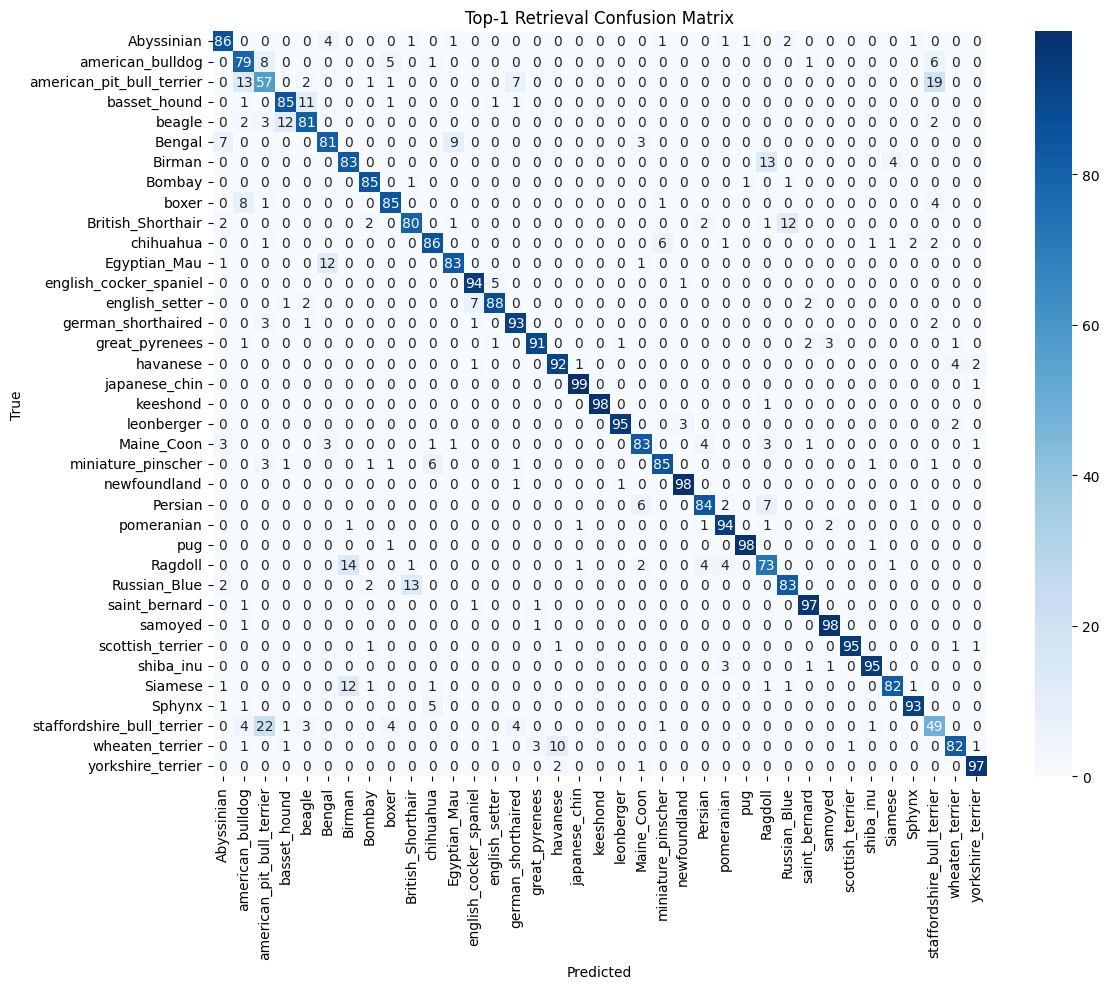


Qualitative Retrieval Examples:


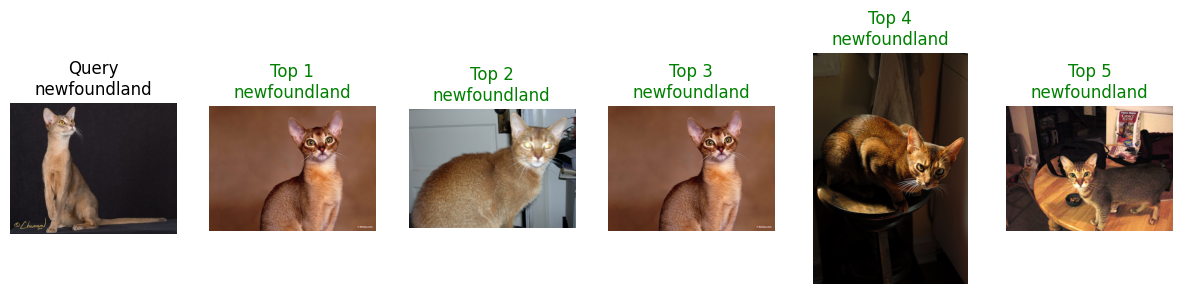

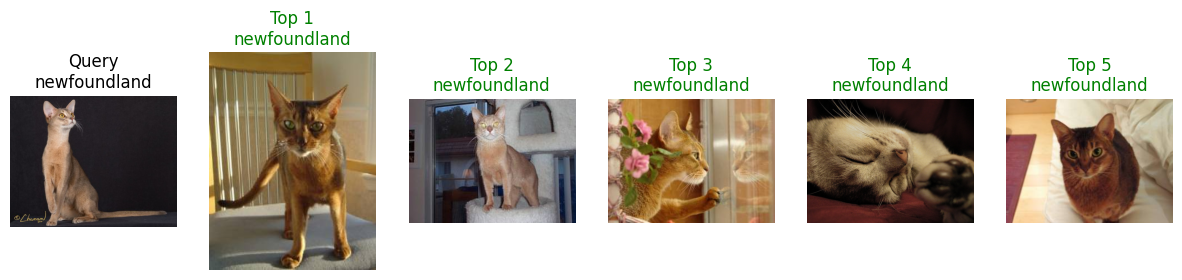

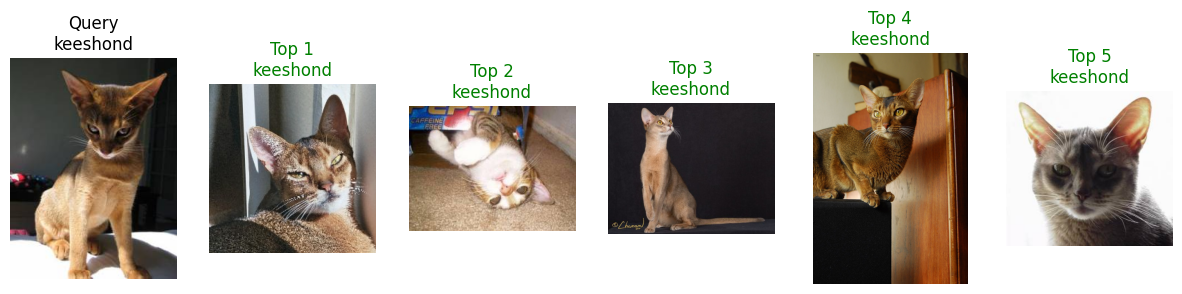

In [15]:
from sklearn.metrics import confusion_matrix

def evaluate_retrieval(model, loader, device, ks=[1, 5, 10]):
    model.eval()
    embeddings = []
    labels = []
    image_paths = []
    
    # Get dataset reference for class names
    dataset = loader.dataset
    if isinstance(dataset, torch.utils.data.Subset):
        dataset = dataset.dataset
    
    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            emb = model(data)
            embeddings.append(emb.cpu().numpy())
            labels.append(label.numpy())
            # Store image paths if available
            if hasattr(dataset, 'image_paths'):
                batch_indices = range(len(label))
                image_paths.extend([dataset.image_paths[i] for i in batch_indices])
    
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    
    # Build FAISS index
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    
    recall_results = {k: [] for k in ks}
    precision_results = {k: [] for k in ks}
    
    # For confusion matrix
    y_true = []
    y_pred = {k: [] for k in ks}
    
    for i in tqdm(range(len(embeddings)), desc="Retrieval Evaluation"):
        query_label = labels[i]
        
        # Search for nearest neighbors (k+1 because we'll exclude self)
        _, indices = index.search(embeddings[i:i+1], max(ks)+1)
        retrieved_indices = indices[0][1:]  # Exclude self
        retrieved_labels = labels[retrieved_indices]
        
        for k in ks:
            top_k_labels = retrieved_labels[:k]
            
            # Recall@K
            relevant = np.sum(top_k_labels == query_label)
            total_relevant = np.sum(labels == query_label) - 1  # exclude self
            recall = relevant / total_relevant if total_relevant > 0 else 0
            recall_results[k].append(recall)
            
            # Precision@K
            precision = relevant / k
            precision_results[k].append(precision)
            
            # For confusion matrix - take top prediction
            y_pred[k].append(top_k_labels[0] if len(top_k_labels) > 0 else -1)
        
        y_true.append(query_label)
    
    retrieval_metrics = {}
    for k in ks:
        retrieval_metrics[f'recall@{k}'] = np.mean(recall_results[k])
        retrieval_metrics[f'precision@{k}'] = np.mean(precision_results[k])
    
    # Plot confusion matrix for top-1 retrieval
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred[1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=dataset.idx_to_class.values(),
                yticklabels=dataset.idx_to_class.values())
    plt.title('Top-1 Retrieval Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Show some qualitative examples
    print("\nQualitative Retrieval Examples:")
    num_examples = 3
    for _ in range(num_examples):
        query_idx = np.random.randint(len(embeddings))
        query_label = labels[query_idx]
        
        # Get top 5 retrievals
        _, indices = index.search(embeddings[query_idx:query_idx+1], 6)
        retrieved_indices = indices[0][1:]  # Exclude self
        
        plt.figure(figsize=(15, 3))
        plt.subplot(1, 6, 1)
        if image_paths:
            img = plt.imread(image_paths[query_idx])
            plt.imshow(img)
        plt.title(f"Query\n{dataset.idx_to_class[query_label]}")
        plt.axis('off')
        
        for i, ret_idx in enumerate(retrieved_indices[:5]):
            plt.subplot(1, 6, i+2)
            if image_paths:
                img = plt.imread(image_paths[ret_idx])
                plt.imshow(img)
            ret_label = labels[ret_idx]
            color = 'green' if ret_label == query_label else 'red'
            plt.title(f"Top {i+1}\n{dataset.idx_to_class[ret_label]}", color=color)
            plt.axis('off')
        plt.show()
    
    return retrieval_metrics

print("\nRunning Retrieval Evaluation...")
retrieval_metrics = evaluate_retrieval(model, test_loader, device)

**Few-shot evaluation (Cosine Distance Is already used in KNN)**

In [16]:
# Cell 10: Few-shot evaluation
def evaluate_few_shot(model, train_loader, test_loader, device, n_way=5, k_shot=5, num_trials=100):
    # Get all embeddings and labels
    def get_all_embeddings(loader):
        model.eval()
        embeddings = []
        labels = []
        with torch.no_grad():
            for data, label in loader:
                data = data.to(device)
                emb = model(data)
                embeddings.append(emb.cpu().numpy())
                labels.append(label.numpy())
        return np.concatenate(embeddings), np.concatenate(labels)
    
    train_embeddings, train_labels = get_all_embeddings(train_loader)
    test_embeddings, test_labels = get_all_embeddings(test_loader)
    
    unique_train_labels = np.unique(train_labels)
    unique_test_labels = np.unique(test_labels)
    
    # Ensure we have enough classes and samples
    if len(unique_test_labels) < n_way:
        raise ValueError(f"Not enough test classes ({len(unique_test_labels)}) for {n_way}-way classification")
    
    # Check each class has enough samples
    min_test_samples = min(np.sum(test_labels == label) for label in unique_test_labels)
    if min_test_samples < 5:  # At least 5 samples per class for query
        raise ValueError(f"Some test classes have fewer than 5 samples")
    
    min_train_samples = min(np.sum(train_labels == label) for label in unique_train_labels)
    if min_train_samples < k_shot:
        raise ValueError(f"Some train classes have fewer than {k_shot} samples")
    
    accuracies = []
    
    for _ in tqdm(range(num_trials), desc="Few-shot Evaluation"):
        # Select n_way random classes from test set
        selected_classes = np.random.choice(unique_test_labels, n_way, replace=False)
        
        support_set = []
        support_labels = []
        query_set = []
        query_labels = []
        
        for class_idx in selected_classes:
            # Get k_shot support examples from train
            class_train_indices = np.where(train_labels == class_idx)[0]
            selected_indices = np.random.choice(class_train_indices, k_shot, replace=False)
            support_set.append(train_embeddings[selected_indices])
            support_labels.extend([class_idx] * k_shot)
            
            # Get query examples from test (5 per class)
            class_test_indices = np.where(test_labels == class_idx)[0]
            selected_indices = np.random.choice(class_test_indices, 5, replace=False)
            query_set.append(test_embeddings[selected_indices])
            query_labels.extend([class_idx] * 5)
        
        support_set = np.concatenate(support_set)
        support_labels = np.array(support_labels)
        query_set = np.concatenate(query_set)
        query_labels = np.array(query_labels)
        
        # KNN classification
        knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
        knn.fit(support_set, support_labels)
        preds = knn.predict(query_set)
        accuracy = np.mean(preds == query_labels)
        accuracies.append(accuracy)
    
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    
    print(f"\n{n_way}-way {k_shot}-shot classification accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    return {'mean_accuracy': mean_accuracy, 'std_accuracy': std_accuracy}

print("\nRunning Few-shot Evaluation...")
few_shot_metrics = evaluate_few_shot(model, train_loader, test_loader, device)


Running Few-shot Evaluation...


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Few-shot Evaluation: 100%|██████████| 100/100 [00:00<00:00, 333.67it/s]


5-way 5-shot classification accuracy: 0.9704 ± 0.0386



Generating Embedding Visualization...


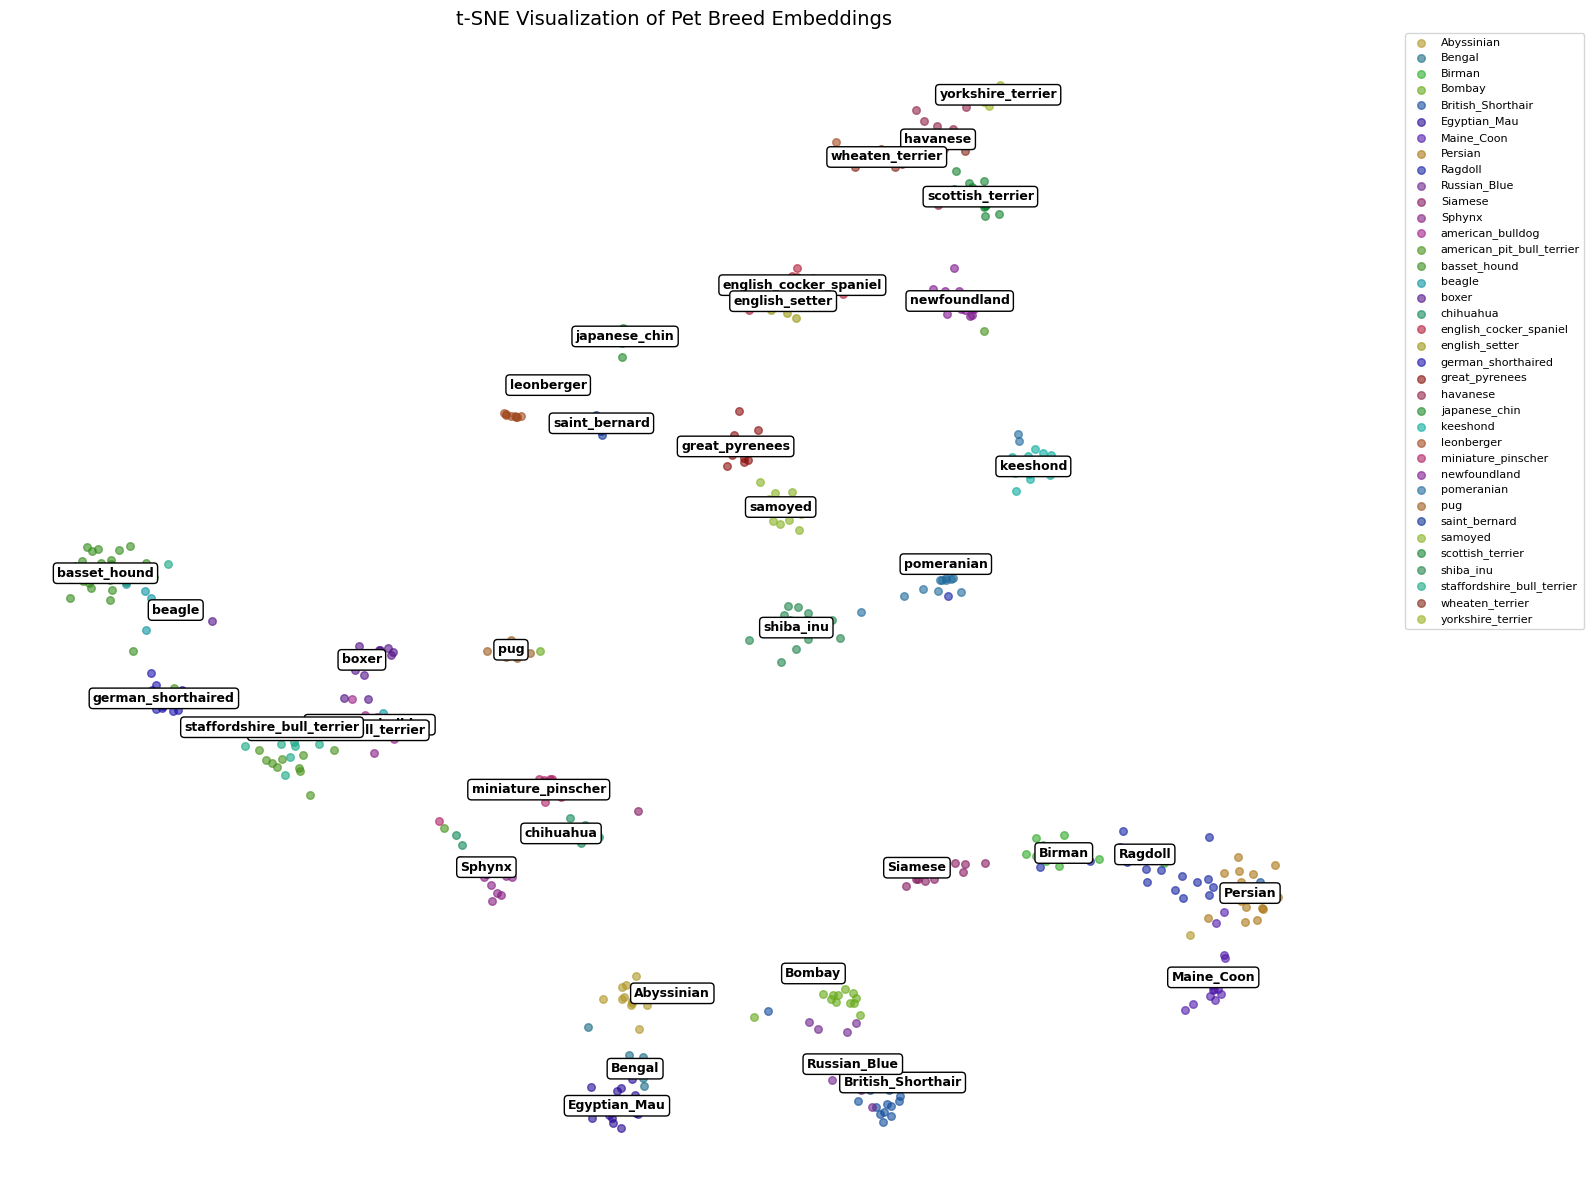

<Figure size 640x480 with 0 Axes>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import matplotlib.colors as mcolors
import random

# Helper: Generate distinct dark colors
def get_better_dark_colors(n, seed=42):
    random.seed(seed)
    hues = list(range(n))
    random.shuffle(hues)
    colors = []
    for i in hues:
        hue = i / n
        saturation = 0.75 + random.uniform(0, 0.2)
        value = 0.5 + random.uniform(0, 0.2)
        rgb = mcolors.hsv_to_rgb((hue, saturation, value))
        colors.append(rgb)
    return colors

# Main visualization function
def visualize_embeddings(model, loader, device, n_samples=500, perplexity=30):
    model.eval()
    embeddings = []
    labels = []
    class_names = []

    dataset = loader.dataset
    if isinstance(dataset, torch.utils.data.Subset):
        dataset = dataset.dataset

    indices = np.random.choice(len(loader.dataset), min(n_samples, len(loader.dataset)), replace=False)

    with torch.no_grad():
        for idx in indices:
            data, label = loader.dataset[idx]
            data = data.unsqueeze(0).to(device)
            emb = model(data)
            embeddings.append(emb.cpu().numpy().squeeze())
            labels.append(label)
            class_names.append(dataset.idx_to_class[label])

    embeddings = np.array(embeddings)
    labels = np.array(labels)
    class_names = np.array(class_names)

    # t-SNE projection
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Visualization
    plt.figure(figsize=(16, 12))
    unique_classes = np.unique(class_names)
    colors = get_better_dark_colors(len(unique_classes))

    legend_handles = []

    for i, class_name in enumerate(unique_classes):
        indices = class_names == class_name
        x = embeddings_2d[indices, 0]
        y = embeddings_2d[indices, 1]

        # Plot points
        scatter = plt.scatter(x, y, color=colors[i], alpha=0.6, s=30, label=class_name)

        # Save for legend
        legend_handles.append(scatter)

        # Add text label at cluster center
        center_x, center_y = x.mean(), y.mean()
        plt.text(center_x, center_y, class_name, fontsize=9, weight='bold', ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.title('t-SNE Visualization of Pet Breed Embeddings', fontsize=14)
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig("tsne_visualization.png", dpi=300, bbox_inches='tight')

print("\nGenerating Embedding Visualization...")
visualize_embeddings(model, test_loader, device)


In [18]:
# Cell 12: Print final results
print("\n=== Final Results ===")
print("\nVerification Metrics:")
print(f"ROC AUC: {verification_metrics['roc_auc']:.4f}")
print(f"Equal Error Rate: {verification_metrics['eer']:.4f}")

print("\nRetrieval Metrics:")
for k, v in retrieval_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nFew-shot Classification:")
print(f"Mean accuracy: {few_shot_metrics['mean_accuracy']:.4f}")
print(f"Standard deviation: {few_shot_metrics['std_accuracy']:.4f}")


=== Final Results ===

Verification Metrics:
ROC AUC: 0.9928
Equal Error Rate: 0.0395

Retrieval Metrics:
recall@1: 0.0089
precision@1: 0.8741
recall@5: 0.0435
precision@5: 0.8553
recall@10: 0.0862
precision@10: 0.8465

Few-shot Classification:
Mean accuracy: 0.9704
Standard deviation: 0.0386


In [19]:
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

# Define the transformation for preprocessing the images
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),  # Converts PIL image to Tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

def check_same_breed_with_visual(img_path1, img_path2, model, device, threshold=0.8):
    model.eval()
    
    def preprocess(img_path):
        """Preprocess the image for model input"""
        image = Image.open(img_path).convert("RGB")
        image_tensor = test_transform(image).unsqueeze(0).to(device)
        return image_tensor, image

    # Preprocess both images
    img_tensor1, img1 = preprocess(img_path1)
    img_tensor2, img2 = preprocess(img_path2)

    # Get embeddings and calculate similarity
    with torch.no_grad():
        emb1 = model(img_tensor1).cpu().numpy()[0]
        emb2 = model(img_tensor2).cpu().numpy()[0]
    
    # Cosine similarity calculation
    similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    is_same = similarity > threshold

    # Extract breed name from the image file path (assuming format 'Breed_xxx.jpg')
    def extract_label(path):
        """Extract breed name from image file name"""
        return os.path.basename(path).split("_")[0]

    label1 = extract_label(img_path1)
    label2 = extract_label(img_path2)

    # Visualization
    plt.figure(figsize=(12, 6))

    # Image 1
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(f"Image 1: {label1}", fontsize=12)
    plt.axis("off")

    # Image 2
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(f"Image 2: {label2}", fontsize=12)
    plt.axis("off")

    # Display similarity info
    plt.suptitle(
        f"{'Same Breed ' if is_same else 'Different Breed '}\nSimilarity Score: {similarity:.4f}",
        fontsize=14, fontweight='bold', y=1.05
    )

    plt.tight_layout()
    plt.show()

    return similarity, is_same


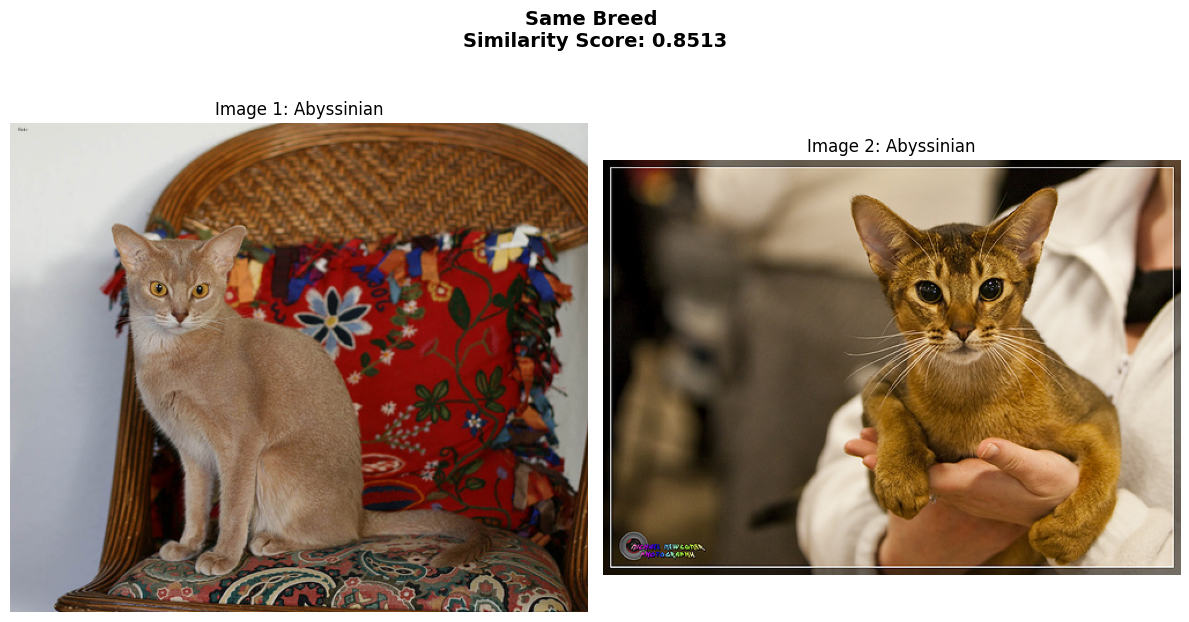

Similarity Score: 0.8513
Same Breed ✅


In [20]:
img_path1 = '/kaggle/input/the-oxfordiiit-pet-dataset/images/Abyssinian_126.jpg'
img_path2 = '/kaggle/input/the-oxfordiiit-pet-dataset/images/Abyssinian_125.jpg'
# Ya koi bhi do images

similarity_score, is_same = check_same_breed_with_visual(img_path1, img_path2, model, device)

print(f"Similarity Score: {similarity_score:.4f}")
print("Same Breed ✅" if is_same else "Different Breed ❌")


In [21]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 38.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 91.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
import gradio as gr

def predict(image1, image2):
    # Save temp images to use file path-based functions
    image1.save("temp1.jpg")
    image2.save("temp2.jpg")
    
    score, is_same = check_same_breed("temp1.jpg", "temp2.jpg", model, device)
    result = "✅ Same Breed" if is_same else "❌ Different Breed"
    return f"Similarity Score: {score:.4f}\n{result}"

demo = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="pil", label="Pet Image 1"),
        gr.Image(type="pil", label="Pet Image 2")
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="🐶🐱 Pet Breed Similarity Checker",
    description="Upload two pet images to check if they belong to the same breed."
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://0c291b3f5e59bcffff.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [23]:

pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


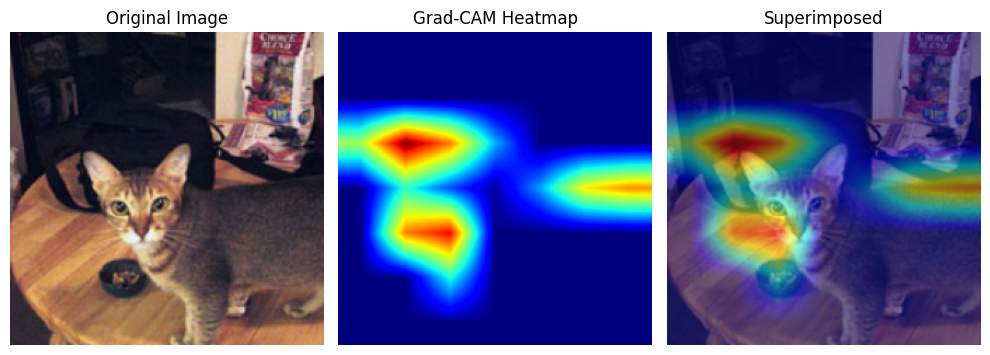

In [24]:
import torch
import cv2

import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):

        self.model = model
        self.target_layer = target_layer
        self.gradient = None
        self.activation = None
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activation = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0].detach()
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_image, target_class=None):
        
        self.model.eval()
        embeddings = self.model(input_image)
        
        # If no target class, use the class with highest similarity
        if target_class is None:
            # For visualization purposes, we'll use the most similar class in the batch
            sim_matrix = torch.mm(embeddings, embeddings.t())
            target_class = torch.argmax(sim_matrix.sum(dim=1))
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass for target class
        one_hot = torch.zeros_like(embeddings)
        one_hot[0, target_class] = 1  # Using target_class as index for simplicity
        
        embeddings.backward(gradient=one_hot, retain_graph=True)
        
        # Get gradients and activations
        gradients = self.gradient[0].cpu().numpy()
        activations = self.activation[0].cpu().numpy()
        
        # Pool gradients
        weights = np.mean(gradients, axis=(1, 2), keepdims=True)
        
        # Weight activations by pooled gradients
        cam = np.sum(weights * activations, axis=0)
        
        # Apply ReLU and normalize
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-10)
        cam = np.uint8(255 * cam)
        
        # Resize to input image size
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        
        # Convert input image to numpy
        img = input_image[0].cpu().numpy().transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())
        
        return cam, img
    
    def visualize(self, input_image, target_class=None):
        """
        Visualize Grad-CAM heatmap over input image
        
        Args:
            input_image: Input image tensor (1, C, H, W)
            target_class: Target class for gradient
        """
        cam, img = self.generate_cam(input_image, target_class)
        
        # Create heatmap
        heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = np.float32(heatmap) / 255
        
        # Superimpose heatmap on image
        superimposed_img = heatmap + np.float32(img)
        superimposed_img = superimposed_img / np.max(superimposed_img)
        
        # Display
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(cam, cmap='jet')
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(superimposed_img)
        plt.title('Superimposed')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Usage example
# Get the target layer (typically the last convolutional layer)
target_layer = None
for module in model.backbone.modules():
    if isinstance(module, torch.nn.Conv2d):
        target_layer = module

if target_layer is None:
    raise ValueError("No convolutional layer found in model")

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Get a sample batch
sample_data, sample_labels = next(iter(test_loader))
sample_image = sample_data[0:1].to(device)

# Generate and visualize Grad-CAM
grad_cam.visualize(sample_image)

#grad_cam.visualize(sample_image, target_class=5)


Training with TripletMargin loss...


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 1: Train Loss = 0.2468, Val Loss = 0.2710


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 2: Train Loss = 0.2178, Val Loss = 0.2677


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 3: Train Loss = 0.2427, Val Loss = 0.2807


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 4: Train Loss = 0.2438, Val Loss = 0.2604


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 5: Train Loss = 0.2454, Val Loss = 0.2534

Training with Contrastive loss...


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 1: Train Loss = 0.8599, Val Loss = 0.8349


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 2: Train Loss = 0.8357, Val Loss = 0.8118


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 3: Train Loss = 0.8524, Val Loss = 0.7698


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 4: Train Loss = 0.8217, Val Loss = 0.8136


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 5: Train Loss = 0.8304, Val Loss = 0.8188

Training with NTXent loss...


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 1: Train Loss = 2.1867, Val Loss = 2.7836


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 2: Train Loss = 2.1739, Val Loss = 2.4215


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 3: Train Loss = 1.8435, Val Loss = 2.2834


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 4: Train Loss = 2.3837, Val Loss = 2.4665


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 5: Train Loss = 2.0745, Val Loss = 1.6378

Training with ArcFace loss...


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 1: Train Loss = 43.2789, Val Loss = 43.3663


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 2: Train Loss = 43.2968, Val Loss = 43.3540


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 3: Train Loss = 43.3529, Val Loss = 43.3099


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 4: Train Loss = 43.4014, Val Loss = 43.2626


Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 5: Train Loss = 43.3416, Val Loss = 43.2642


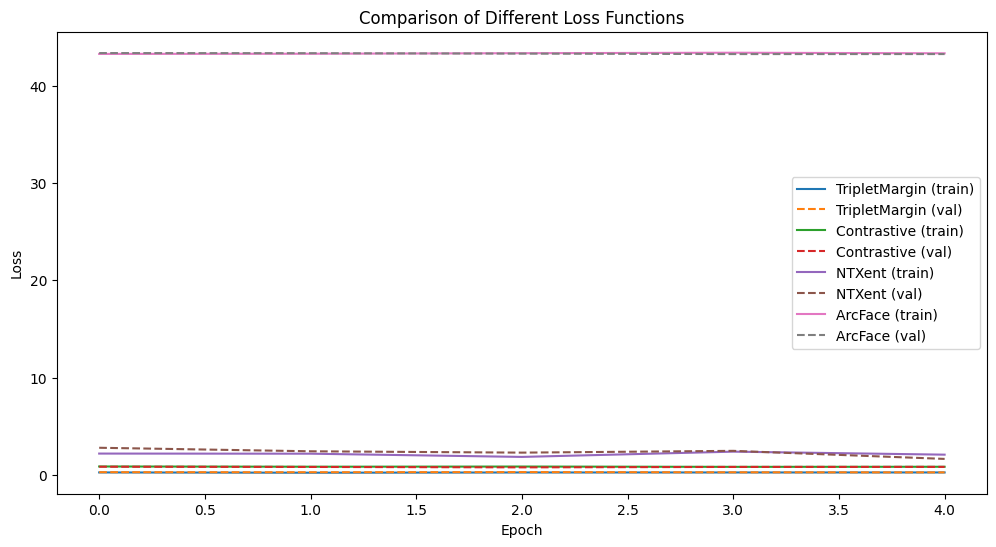

In [25]:
import torch
from pytorch_metric_learning import losses
import copy


class LossFunctionComparator:
    def __init__(self, embedding_size=128, device='cuda'):
        self.loss_functions = {
            "TripletMargin": losses.TripletMarginLoss(margin=0.2),
            "Contrastive": losses.ContrastiveLoss(pos_margin=0, neg_margin=0.2),
            "NTXent": losses.NTXentLoss(temperature=0.07),
            "ArcFace": losses.ArcFaceLoss(num_classes=37, embedding_size=embedding_size)
        }
        self.device = device
        
    def get_loss_function(self, name):
        """Get initialized loss function by name"""
        if name not in self.loss_functions:
            raise ValueError(f"Unknown loss function: {name}. Available: {list(self.loss_functions.keys())}")
        return self.loss_functions[name].to(self.device)
    
    def compare_losses(self, model, train_loader, val_loader, optimizer, num_epochs=5):
        """Compare different loss functions"""
        results = {}
        
        for loss_name in self.loss_functions:
            print(f"\nTraining with {loss_name} loss...")
            model_copy = copy.deepcopy(model).to(self.device)
            loss_func = self.get_loss_function(loss_name)
            
            # Use a basic miner for all losses
            miner = miners.MultiSimilarityMiner(epsilon=0.1) if loss_name != "ArcFace" else None
            
            train_losses = []
            val_losses = []
            
            for epoch in range(1, num_epochs + 1):
                # Training
                model_copy.train()
                total_loss = 0
                
                for data, labels in train_loader:
                    data, labels = data.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()
                    
                    embeddings = model_copy(data)
                    
                    if miner:
                        indices_tuple = miner(embeddings, labels)
                        loss = loss_func(embeddings, labels, indices_tuple)
                    else:
                        loss = loss_func(embeddings, labels)
                    
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                
                avg_train_loss = total_loss / len(train_loader)
                train_losses.append(avg_train_loss)
                
                # Validation
                avg_val_loss = self.validate(model_copy, loss_func, val_loader, miner)
                val_losses.append(avg_val_loss)
                
                print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
            
            results[loss_name] = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'final_val_loss': val_losses[-1]
            }
        
        return results
    
    def validate(self, model, loss_func, val_loader, miner=None):
        """Validation function"""
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                embeddings = model(data)
                
                if miner:
                    indices_tuple = miner(embeddings, labels)
                    loss = loss_func(embeddings, labels, indices_tuple)
                else:
                    loss = loss_func(embeddings, labels)
                
                val_loss += loss.item()
        
        return val_loss / len(val_loader)

# Usage example
# Initialize comparator
loss_comparator = LossFunctionComparator(embedding_size=128, device=device)

# Compare loss functions
results = loss_comparator.compare_losses(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=5
)

# Plot results
plt.figure(figsize=(12, 6))
for loss_name, data in results.items():
    plt.plot(data['train_losses'], label=f"{loss_name} (train)")
    plt.plot(data['val_losses'], '--', label=f"{loss_name} (val)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Different Loss Functions')
plt.legend()
plt.show()